# Multi-category Image Classification: Dog Breeds

This notebook documents an approach to the categorical classification of images of different Dogs Breeds utilizing the best practices of the fast.ai libraries built on top of PyTorch. The approach will start with a convolutional model pre-trained on the ImageNet dataset. Additional/final dense layers are appended to the base convolutional layers. This particular notebook borrows heavily from fast.ai's Lesson 1-2 Notebooks and Videos 1-3. 

*Author*: ksferguson (K. Scott Ferguson)

*Type*: Deep Learning

*Stack*: fast.ai over pyTorch

*Pattern*: Multi-category Image Classification

*Problem*: Predict which dog breed is in image

*Dataset*: Kaggle - Dog Breed Indentification

## fast.ai Best Practices 

### Train a world-class image classifier 
(adapted from fast.ai Lessons 1-3 Videos & Notebooks)

A. Quick Start
  * Use pre-trained Imagenet model
  * Precompute activations in convolutional layers

B. Explore Data

C. Find Learning Rate
  * Find highest learning rate where loss is still decreasing well

D. Train Last Layer(s)
  * Use pre-trained Imagenet model
  * Precompute activations in convolutional layers
  * Use highest learning rate where loss is still decreasing
  * Train 1-2 Epochs

E. Deep Train Last Layer(s)
  * Start recomputing activations in convolutional layers
  * Augment image data with pans, flips, & zooms
  * Restart SGD every epoch (cycle_len=1)
  * Train 2-3 Epochs

F. Train Full Model
  * Unfreeze All Layers
  * Recheck Learning Rate for Final Layer
  * Use Differential Learning Rates
  * SGD Differential Restart, set cycle_mult=2
  * Use Test Time Data Augmentation

G. Analyze Results

## Machine & Notebook Setup

Notebook work is primarily executed on PaperSpace fast.ai template on an 8 CPU, Quadro P5000 GPU, 30 GB RAM machine. Alternatively, a Dell 7759 w GTX 960M was similarly configured although this was a complex and iterative, systems configuration task. Use of PaperSpace is highly encouraged.

* Ubuntu Setup Notes for Dell 7559 with GTX 960M: https://gist.github.com/ksferguson/a6eba79df658826cacb629dcc14992eaPaperSpace 
* fast.ai PaperSpace Setup Notes: https://gist.github.com/ksferguson/0b384e892689617d1539d35c1254eb01 

### fast.ai prelims
Ported largely unchanged.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

### Data Prelims

This problem utilizes one of the fast.ai supported data patterns, based on directory paths (as opposed to e.g. a .csv file with appropriate training set/target label attributes). 

With this pattern, the expectation is that a data directory exists, e.g. "data/dogscats/". Under this folder, there are e.g. "train" and "valid" folders each with a subdirectory for "dogs" and also one for "cats". Hence the target labels are read off the folder geometry.

An initial image size sz is also set to 224 pixels (square, i.e. 224 x 224 or ~50K pixels x 3 color channels for an input tensor with 150,528 data points).

Note: The "data" folder is be a symbolic link inside the repo so that it actually lives outside of the github.com repo.

In [6]:
PATH = "data/dog-breed-identification/"
sz=224

In [7]:
!ls {PATH}

labels.csv	sample_submission.csv	   test.zip  train.zip
labels.csv.zip	sample_submission.csv.zip  tmp
models		test			   train


In [8]:
label_csv = f'{PATH}labels.csv'
print(f'{PATH}labels.csv')
n = len(list(open(label_csv)))-1
n
val_idxs = get_cv_idxs(n)
n, len(val_idxs), val_idxs

data/dog-breed-identification/labels.csv


(10222, 2044, array([2882, 4514, 7717, ..., 8922, 6774,   37]))

In [9]:
label_df = pd.read_csv(label_csv)

In [10]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


## A. Quick Start

Use pretrained ImageNet model to start with precomputed activations for initial convolutional layers.

### Use Pre-Trained ImageNet model

Since the pictures are generally similar to ImageNet, we are using resnext101_64 as a base for the training. 

### Precompute Activations in Convolutional Layers

Set precompute=True for learner to compute activations once prior to training. Later we will disable this initial speedup.

In [12]:
# Uncomment the line below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [13]:
sz = 224
bs = 58
arch = resnext101_64
tfms=tfms_from_model(arch, sz)
#tfms = tfms_from_model (arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', 
                                    val_idxs=val_idxs, suffix='.jpg',
                                    tfms=tfms, bs=bs)

In [14]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 4)

epoch      trn_loss   val_loss   accuracy                    
    0      0.904083   0.405558   0.906067  
    1      0.429966   0.299641   0.92319                     
    2      0.285663   0.288035   0.92319                     
    3      0.216567   0.27609    0.924168                    



[array([0.27609]), 0.9241682982141491]

In [15]:
learn.save('224_A')

In [16]:
#learn.load('224_A')

## B. Explore Data & Initial Predictions



In [17]:
# This is the label for a val data
data.val_y

array([ 19,  15,   7, ..., 109,   3,  28])

In [18]:
data.classes[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [19]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

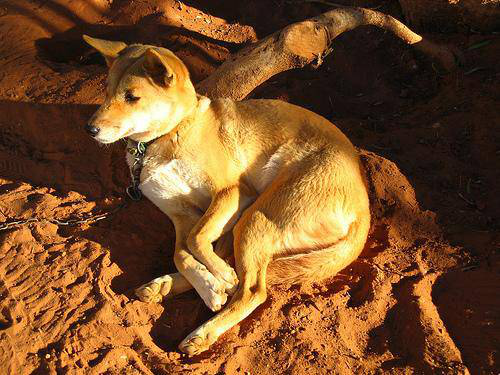

In [20]:
img = PIL.Image.open(fn); img

In [21]:
img.size

(500, 375)

In [22]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [23]:
row_sz, col_sz = list(zip(*size_d.values()))

In [24]:
row_sz=np.array(row_sz); col_sz=np.array(col_sz)

In [25]:
row_sz[:5]

array([500, 500, 500, 500, 500])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

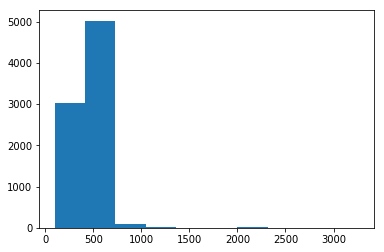

In [26]:
plt.hist(row_sz)

In [27]:
col_sz[:5]

array([375, 375, 500, 375, 470])

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

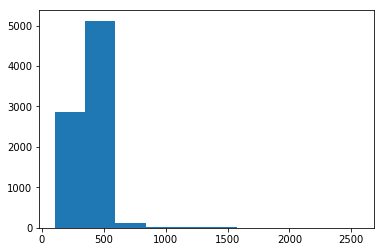

In [28]:
plt.hist(col_sz)

In [29]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [30]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

In [31]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2044, 120)

In [32]:
log_preds[1,15]

-0.009671211

In [33]:
np.exp(log_preds[1,15])

0.9903754

In [34]:
preds = np.argmax(log_preds, axis=1)
#for binary classification
#probs = np.exp(log_preds[:,1])        
probs = np.exp([log_preds[i,x] for i, x in enumerate(preds)])

In [35]:
preds[:7]

array([19, 15,  7, 99, 73, 81, 21])

In [36]:
probs[:7]

array([0.99702, 0.99038, 0.99566, 0.87831, 0.99372, 0.33085, 0.99888], dtype=float32)

In [37]:
probs.shape

(2044,)

In [38]:
preds.shape

(2044,)

In [39]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 6, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [40]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [41]:
data.val_y[1], data.classes[data.val_y[1]]

(15, 'bluetick')

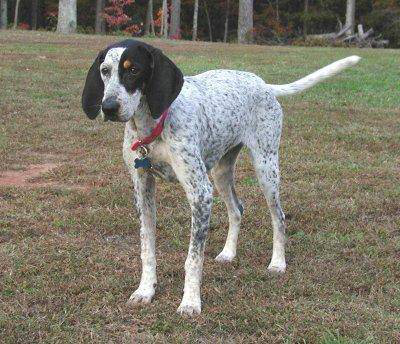

In [42]:
PIL.Image.open(PATH+data.val_ds.fnames[1])

In [43]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [44]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [45]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

#ksf - use preds instead of probs for multi-categorical
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    #[ ] ksf -title too long, need to clean up plots
    title_probs = [str(probs[x]) + ' ' +str(preds[x]) + ' ' 
                   +  data.classes[preds[x]] + ' ' 
                   + str(data.val_y[x]) + ' ' 
                   + data.classes[data.val_y[x]] for x in idxs]
    print(title)
    return plots(imgs, rows=3, titles=title_probs, figsize=(16,8))

Correctly classified (prob, pred, valid)


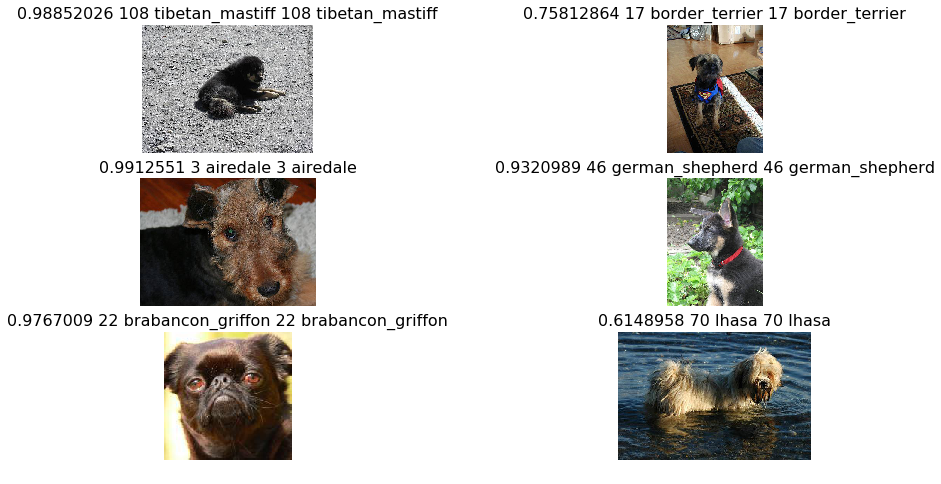

In [46]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified (prob, pred, valid)")

Incorrectly classified (prob, pred, valid)


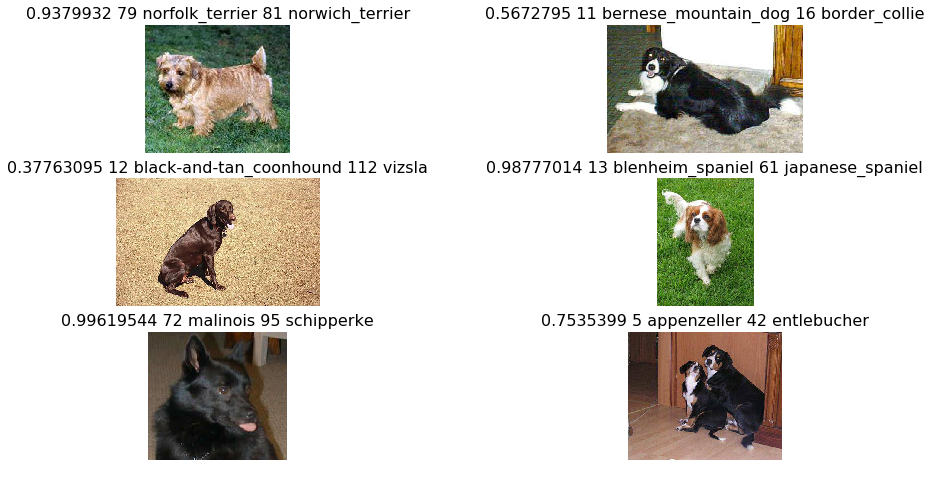

In [47]:
# 2. A few incorrect labels at random

plot_val_with_title(rand_by_correct(False), "Incorrectly classified (prob, pred, valid)")

In [48]:
#ksf simplified from binary case

def most_by_mask(mask):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(probs[idxs])[::-1][:6]]

def most_by_correct(is_correct): 
    return most_by_mask(((preds == data.val_y)==is_correct))

Most correct (prob, pred, valid)


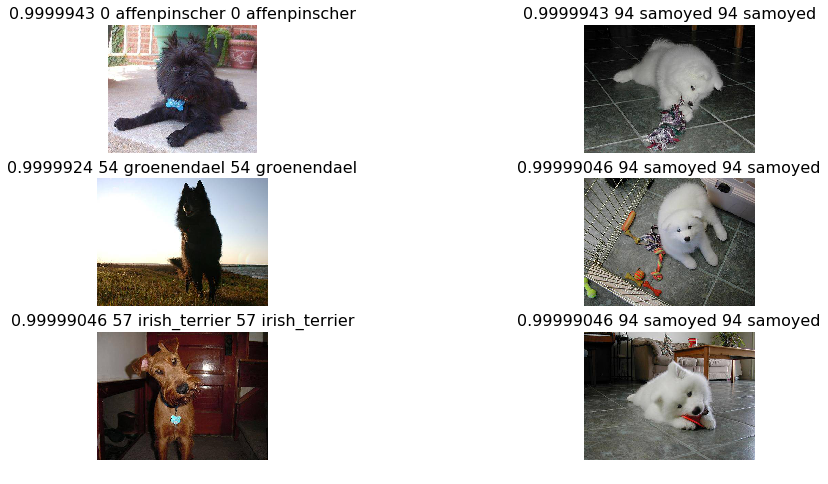

In [49]:
plot_val_with_title(most_by_correct(True), "Most correct (prob, pred, valid)")

Most incorrect (prob, pred, valid)


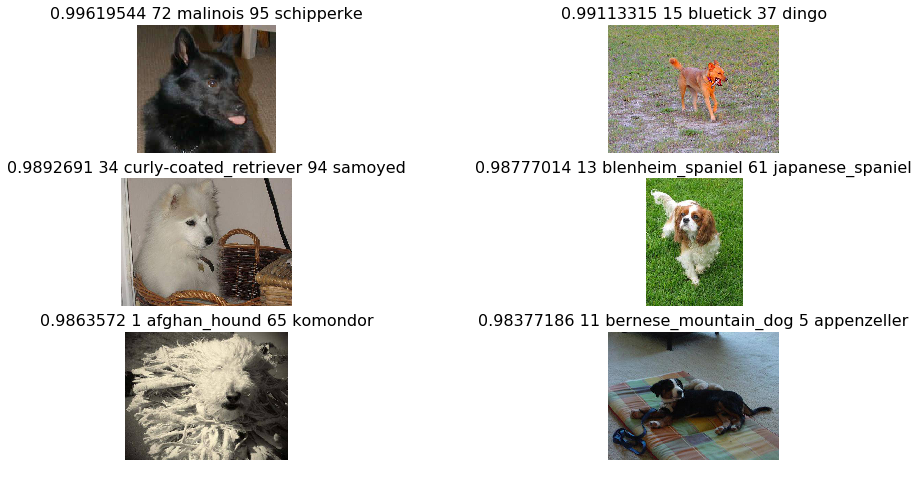

In [50]:
plot_val_with_title(most_by_correct(False), "Most incorrect (prob, pred, valid)")

In [51]:
most_uncertain = np.argsort(np.abs(probs))[:6]

Most uncertain predictions (prob, pred, valid)


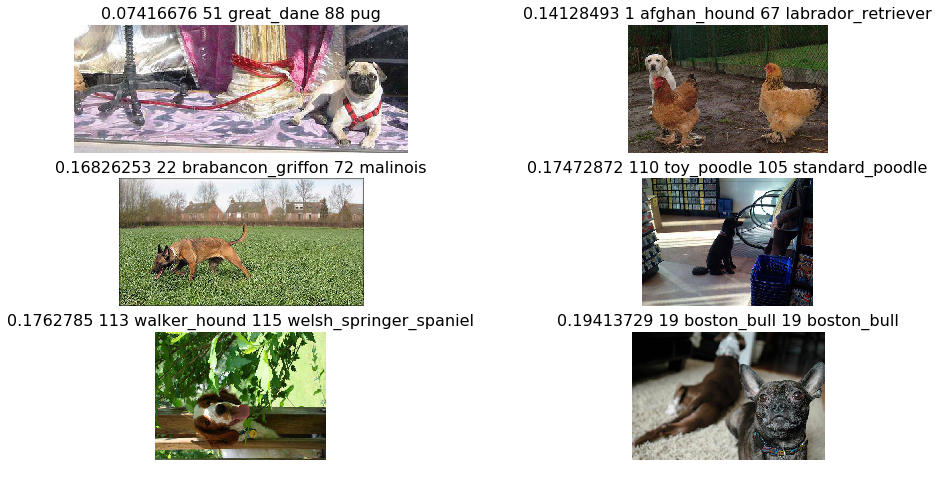

In [52]:
plot_val_with_title(most_uncertain, "Most uncertain predictions (prob, pred, valid)")

## C. Find Learning Rate

Utilize the fast.ai library to determine the best initial learning rate for the last layer(s).

In [53]:
def get_data (sz, bs):
    tfms = tfms_from_model (arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv',
                                        test_name='test', #number_workers=4,
                                        val_idxs=val_idxs, suffix='.jpg',
                                        tfms=tfms, bs=bs)
    return data if sz>224 else data.resize(224, 'tmp')

In [54]:
#learn = ConvLearner.pretrained(arch, data, precompute=True)
learn = ConvLearner.pretrained(arch, get_data(sz, bs), precompute=True)

In [55]:
lrf=learn.lr_find()

 90%|█████████ | 127/141 [00:03<00:00, 35.58it/s, loss=11.4]


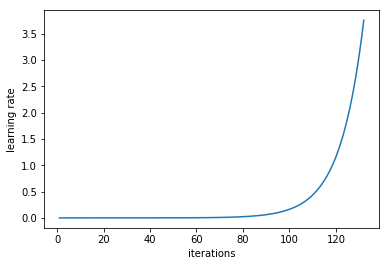

In [56]:
learn.sched.plot_lr()

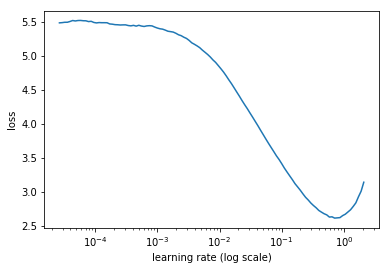

In [57]:
learn.sched.plot()

Loss is still rapidly dropping at $10^{-1}$, so we will set lr=1e-1

## D. Train Last Layer(s)

### Use pre-trained Imagenet model
Same as quick start.

### Precompute activations in convolutional layers
Same as quick start.

### Use highest learning rate where loss is still decreasing
lr = $10^{-1}$

### Train 1-2 Epochs

In [58]:
#quick start gave us 5 epochs with no transforms at 92% accuracy

#comment out next line to restart from scratch
#arch=resnext101_64

#use same get_data function above

learn = ConvLearner.pretrained(arch, get_data(sz, bs), precompute=True)
learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.724829   0.391593   0.883072  
    1      0.467147   0.444135   0.880137                    



[array([0.44413]), 0.8801369921918485]

In [59]:
learn.save('224_D')

In [60]:
#learn.load('224_D')

## E. Deep Train Last Layer 

### Start recomputing activations in convolutional layers
Set precompute=False

### Restart SGD every epoch (cycle_len=1)
Set cycle_len=1 for restart stochastic gradient descent by raising the learning rate up higher again (e.g. to help jump out of 'narrow' minima)

### Train 2-3 Epochs


### Augment image data with pans, flips, & zooms
Use tfms_from_model() to build various alternate data inputs
transform_side_on is for images take from side (as opposed to top down)

In [61]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [62]:
def get_augs():
    data = get_data(sz, bs)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [63]:
ims = np.stack([get_augs() for i in range(6)])

Example data augmentation for side images:

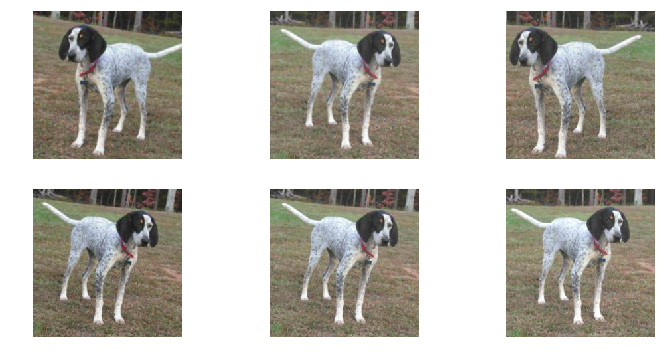

In [64]:
plots(ims, rows=2)

In [65]:
learn = ConvLearner.pretrained(arch, get_data(sz, bs), precompute=False)

In [66]:
learn.fit(1e-1, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.770493   0.323361   0.8909    
    1      0.530811   0.309521   0.899217                    
    2      0.420602   0.294808   0.903131                    



[array([0.29481]), 0.9031311226917573]

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_E')

In [ ]:
#learn.load('224_E')

## F. Train Full Model

### Unfreeze All Layers
All layers can now be trained.

### Use Differential Learning Rates
But we don't want the early convolutional layers disturbed as they presumably capture important low level features, so we will use differential rates, applying smaller learning rates to earlier layers (in three sets/rates). We will set earlier layers to 3x-10x lower learning rate than next higher layer.

### Use Test Time Data Augmentation
At Test Time, we can use additional data pans, zooms, & flips to bring otherwise hidden pixels or distorted areas into better focus.

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])
learn.unfreeze
lrf=learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
#[ ] fix 300 boost in get data first...
#learn.set_data(get data(299, bs))
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('224_F')

In [ ]:
#learn.load('224_F')

### Test Time Augmentation

Find highest probablity for each set of the multiple generated images

In [ ]:
from sklearn import metrics
log_preds,y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

## G. Analyze Results



### Confusion Matrix

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Pictures

## References

fast.ai Deep Learning Course 1:
  * Lesson 1 Notebook, Image classification with Convolutional Neural Networks, https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb
  * Lesson 2 Notebook, Multi-label classification, https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb
  * Lesson 1 Video, Recognizing Cats & Dogs, http://course.fast.ai/lessons/lesson3.html 
  * Lesson 2 Video, Convolutional Neural Networks, http://course.fast.ai/lessons/lesson3.html 
  * Lesson 3 Video, Improving Your Image Classifier, http://course.fast.ai/lessons/lesson3.html 
  
Datasets/Competitions:
  * https://www.kaggle.com/c/dogs-vs-cats
  * https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition (same data set as original)
  * https://www.kaggle.com/c/kmlc-challenge-1-cats-vs-dogs/data (new Google data set) 
  
References:

<div class="cite2c-biblio"></div>